# Model evaluation with ROC AUC

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# data preparation

df = pd.read_csv("churn.csv")

df.columns = df.columns.str.lower().str.replace(" ", "_")
categorical_columns = list(df.dtypes[df.dtypes == "object"].index)
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(" ", "_")
df.totalcharges = pd.to_numeric(df.totalcharges, errors="coerce")
df.totalcharges = df.totalcharges.fillna(0)
df.churn = (df.churn == "yes").astype(int)

In [4]:
df.head(1)

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-vhveg,female,0,yes,no,1,no,no_phone_service,dsl,no,...,no,no,no,no,month-to-month,yes,electronic_check,29.85,29.85,0


In [5]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train["churn"]
del df_val["churn"]
del df_test["churn"]

# note that df_full_train still contains the target variable
# this set will be later used for k-fold cross-validation

In [8]:
print(f"train shape: {df_train.shape}")
print(f"val shape: {df_val.shape}")
print(f"test shape: {df_test.shape}")
print(f"full train shape: {df_full_train.shape}")

train shape: (4225, 20)
val shape: (1409, 20)
test shape: (1409, 20)
full train shape: (5634, 21)


In [9]:
numerical = ["tenure", "monthlycharges", "totalcharges"]

categorical = [
    "gender",
    "seniorcitizen",
    "partner",
    "dependents",
    "phoneservice",
    "multiplelines",
    "internetservice",
    "onlinesecurity",
    "onlinebackup",
    "deviceprotection",
    "techsupport",
    "streamingtv",
    "streamingmovies",
    "contract",
    "paperlessbilling",
    "paymentmethod",
]

In [10]:
# convert dataframes to one-hot encoding mixed with numericals

from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient="records")
dv.fit(train_dict)
X_train = dv.transform(train_dict)
X_val = dv.transform(df_val[categorical + numerical].to_dict(orient="records"))

In [14]:
# train a reference model - no hyperparameter tuning

from sklearn.linear_model import LogisticRegression

reference_model = LogisticRegression(max_iter=20_000)
reference_model.fit(X_train, y_train)

LogisticRegression(max_iter=20000)

## Reference model accuracy

In [19]:
y_prob = reference_model.predict_proba(X_val) # pairwise neg / pos
y_pred = y_prob[:, 1] # positive class probability
y_decision = y_pred >= 0.5 # ref threshold

# calculate accuracy manually

acc = (y_val == y_decision).mean()
print(f"ref model accuracy = {acc:.3f} on {len(X_val)} samples")

ref model accuracy = 0.803 on 1409 samples


In [20]:
# distribution of pos / neg in validation data

print(f"positive class rate in validation data = {y_val.mean():.3f}")

positive class rate in validation data = 0.274


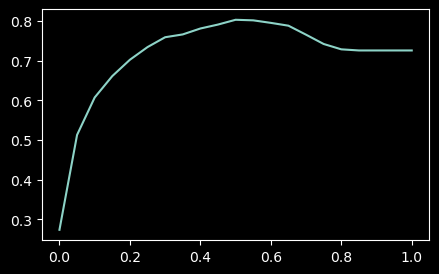

In [27]:
# dependency of accuracy on threshold

thresholds = np.linspace(0, 1, 21)

acc_scores = []
for t in thresholds:
    y_decision = y_pred >= t
    acc = (y_val == y_decision).mean()
    acc_scores.append(acc)

plt.subplots(figsize=(5, 3))
plt.plot(thresholds, acc_scores, label="accuracy")

## Confusion matrix

Building manually in Numpy

In [33]:
all_pos = (y_val == 1)
all_neg = (y_val == 0)
pred_pos = (y_pred >= 0.5)
pred_neg = (y_pred < 0.5)
true_pos = (all_pos & pred_pos)
true_neg = (all_neg & pred_neg)
false_pos = (all_neg & pred_pos)
false_neg = (all_pos & pred_neg)

cm = np.array([
    [true_neg.sum(), false_neg.sum()],
    [false_pos.sum(), true_pos.sum()]
])

print(cm) # predicted are down, actual are across
print((cm / cm.sum()).round(2)) # diagonal sum is accuracy

[[920 174]
 [103 212]]
[[0.65 0.12]
 [0.07 0.15]]


In [35]:
# or use a shortcut!
# but note that sklearn uses a different convention for confusion matrix
# the axes are swapped
# actuals are down, predictions are across

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, y_pred >= 0.5)
print(cm)
print(cm.T)

[[920 103]
 [174 212]]
[[920 174]
 [103 212]]


## Precision and recall

In [36]:
# precision is the number of correctly flagged positives

prec = true_pos.sum() / (true_pos.sum() + false_pos.sum())
print(f"precision = {prec:.3f}")

precision = 0.673


In [37]:
# recall is the number of detected positives

rec = true_pos.sum() / (true_pos.sum() + false_neg.sum())
print(f"recall = {rec:.3f}")

recall = 0.549


In [38]:
# using sklearn

from sklearn.metrics import precision_score, recall_score

prec = precision_score(y_val, y_pred >= 0.5)
print(f"precision = {prec:.3f}")

rec = recall_score(y_val, y_pred >= 0.5)
print(f"recall = {rec:.3f}")

precision = 0.673
recall = 0.549


In [39]:
# f1 score is the harmonic mean of precision and recall
# it's a special case of F-beta score with beta = 1

f1 = 2 * (prec * rec) / (prec + rec)
print(f"f1 = {f1:.3f}")

f1 = 0.605


## P/R versus thresholds

Verify precision and recall for different cutoff thresholds

In [40]:
# compute tp, fp, fn, tn for all thresholds

thresholds = np.linspace(0, 1, 101)

scores = []
for t in thresholds:
    y_decision = y_pred >= t
    tp = (y_val == 1) & (y_decision == 1)
    fp = (y_val == 0) & (y_decision == 1)
    fn = (y_val == 1) & (y_decision == 0)
    tn = (y_val == 0) & (y_decision == 0)
    scores.append((t, tp.sum(), fp.sum(), fn.sum(), tn.sum()))

In [45]:
# convert into dataframe for convenience

columns = ["threshold", "tp", "fp", "fn", "tn"]
ref_df_scores = pd.DataFrame(scores, columns=columns)

# show distribution of tp, fp, fn, tn with 10 steps

ref_df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,386,1023,0,0
10,0.1,366,533,20,490
20,0.2,339,372,47,651
30,0.3,292,245,94,778
40,0.4,254,176,132,847
50,0.5,212,103,174,920
60,0.6,151,53,235,970
70,0.7,69,13,317,1010
80,0.8,4,0,382,1023
90,0.9,0,0,386,1023


In [49]:
# calculate fpr, tpr for all thresholds
# fpr is the ratio of fps to all negatives ("false alarm rate")
# tpr is the ratio of tps to all positives (equals recall)

ref_df_scores["fpr"] = (ref_df_scores.fp / (ref_df_scores.fp + ref_df_scores.tn).round(4))
ref_df_scores["tpr"] = (ref_df_scores.tp / (ref_df_scores.tp + ref_df_scores.fn)).round(4)

ref_df_scores[::10]

,threshold,tp,fp,fn,tn,fpr,tpr
0,0.0,386,1023,0,0,1.000000,1.0000
10,0.1,366,533,20,490,0.521017,0.9482
20,0.2,339,372,47,651,0.363636,0.8782
30,0.3,292,245,94,778,0.239492,0.7565
40,0.4,254,176,132,847,0.172043,0.6580
50,0.5,212,103,174,920,0.100684,0.5492
60,0.6,151,53,235,970,0.051808,0.3912
70,0.7,69,13,317,1010,0.012708,0.1788
80,0.8,4,0,382,1023,0.000000,0.0104
90,0.9,0,0,386,1023,0.000000,0.0000


## ROC intuition

By starting from t=0 and moving threshold upwards we start to capture more and more positives. Initially they will be mostly true but as threshold moves lower there will be more and more false detections.

The optimization problem is to find the threshold where tradeoff is still acceptable for given use case.

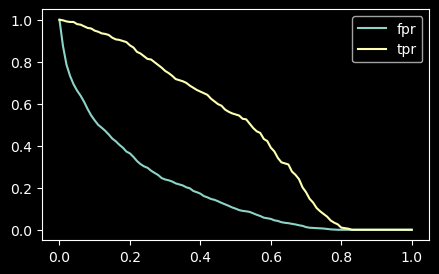

In [51]:
# plotting FPR and TPR separately - for all thresholds

plt.subplots(figsize=(5, 3))
plt.plot(ref_df_scores.threshold, ref_df_scores.fpr, label="fpr")
plt.plot(ref_df_scores.threshold, ref_df_scores.tpr, label="tpr")
plt.legend()

## Plotting FPR / TPR for random classifier

Relationship between FPR and TPR for a model that predicts using a uniform distribution.

## Plotting FPR / TPR for perfect classifier

Relationship between FPR and TPR for ideal selection.

## ROC curve

Plotting x=FPR against y=TPR produces a ROC tradeoff curve.